### Initialize notebook

In [1]:
#!/home/akhanal1/Spring2018/pl-env/bin/python3.5
# Torch imports

import os
import sys
sys.path.append('/home/ak/PycharmProjects/ature')
os.chdir('/home/ak/PycharmProjects/ature')


import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
import PIL.Image as IMG
from torch.utils.data.sampler import WeightedRandomSampler
from sklearn.metrics import classification_report
from neuralnet.utils.weights_utils import initialize_weights

import matplotlib.pyplot as plt
import numpy as np

from commons.segmentation import AtureTest
from commons.IMAGE import SegmentedImage


from utils import img_utils as imgutil
from commons.IMAGE import Image
from neuralnet.hybridnet.hybridnet_trainer import HybridNNTrainer
from neuralnet.hybridnet.hybridnet_dataloader import PatchesGenerator
import neuralnet.utils.measurements as mnt
import neuralnet.utils.data_utils as nndutils

%load_ext autoreload
%autoreload 2

/home/ak/anaconda3/envs/ature_env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [11]:
### Define folders. Create if needed.
sep = os.sep
Dirs = {}
Dirs['checkpoint']   = 'assests' +sep+ 'nnet_models'
Dirs['data']      = 'data'+sep+'DRIVE'+sep+'training'
Dirs['images']    = Dirs['data'] +sep+ 'images'
Dirs['mask']      = Dirs['data'] +sep+ 'mask'
Dirs['truth']     = Dirs['data'] +sep+ '1st_manual'

TestDirs = {}
TestDirs['data']      = 'data'+sep+'DRIVE'+sep+'test'
TestDirs['images']    = TestDirs['data'] +sep+ 'test_images'
TestDirs['mask']      = TestDirs['data'] +sep+ 'mask'
TestDirs['truth']     = TestDirs['data'] +sep+ '1st_manual'

ValidationDirs = {}
ValidationDirs['data']      = 'data'+sep+'DRIVE'+sep+'test'
ValidationDirs['images']    = ValidationDirs['data'] +sep+ 'validation_images'
ValidationDirs['mask']      = ValidationDirs['data'] +sep+ 'mask'
ValidationDirs['truth']     = ValidationDirs['data'] +sep+ '1st_manual'

for k, folder in Dirs.items():
    os.makedirs(folder, exist_ok=True)
for k, folder in TestDirs.items():
    os.makedirs(folder, exist_ok=True)
for k, folder in ValidationDirs.items():
    os.makedirs(folder, exist_ok=True)

def get_mask_file(file_name): 
    return file_name.split('_')[0] + '_training_mask.gif'

def get_ground_truth_file(file_name): 
    return file_name.split('_')[0] + '_manual1.gif'

def get_mask_file_test(file_name): 
    return file_name.split('_')[0] + '_test_mask.gif'

classes = { 'background': 0, 'vessel': 1,}
batch_size = 2
num_classes = len(classes)
epochs = 5
num_rows, num_cols = 52, 565 #height by width of image of training img
use_gpu = False
pixel_offset = 5
#### Images to train/validate per epoch ####
train_size = None
validation_size = None
checkpoint_file = 'PytorchCheckpointHybridrow64Smart1DeepAUGMENT.nn.tar'

### Define the network

In [12]:
class Net(nn.Module):
    def __init__(self, input_width, input_height, channels):
        super(Net, self).__init__()
        
        self.channels = channels
        self.width = input_width
        self.height = input_height
        print(self.width, self.height)
    
        self.kern_size = 3
        self.kern_stride = 1
        self.kern_padding = 1
        self.conv1 = nn.Conv2d(self.channels, 64, self.kern_size, 
                               stride=self.kern_stride, padding=self.kern_padding)
        self.conv1_bn = nn.BatchNorm2d(64)
        self.width = self._get_output_size(self.width, self.kern_size, self.kern_padding, self.kern_stride)
        self.height = self._get_output_size(self.height, self.kern_size, self.kern_padding, self.kern_stride)
        print(self.width, self.height)
        
        self.kern_size = 3
        self.kern_stride = 1    
        self.kern_padding = 1
        self.conv2 = nn.Conv2d(64, 64, self.kern_size, 
                               stride=self.kern_stride, padding=self.kern_padding)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.width = self._get_output_size(self.width, self.kern_size, self.kern_padding, self.kern_stride)
        self.height = self._get_output_size(self.height, self.kern_size, self.kern_padding, self.kern_stride)
        print(self.width, self.height)
        
        self.kern_size = 3
        self.kern_stride = 1      
        self.kern_padding = 1
        self.conv3 = nn.Conv2d(64, 128, self.kern_size, 
                               stride=self.kern_stride, padding=self.kern_padding)
        self.conv3_bn = nn.BatchNorm2d(128)
        self.width = self._get_output_size(self.width, self.kern_size, self.kern_padding, self.kern_stride)
        self.height = self._get_output_size(self.height, self.kern_size, self.kern_padding, self.kern_stride)
        print(self.width, self.height)
        
        self.kern_size = 3
        self.kern_stride = 1      
        self.kern_padding = 1
        self.conv4 = nn.Conv2d(128, 64, self.kern_size, 
                               stride=self.kern_stride, padding=self.kern_padding)
        self.conv4_bn = nn.BatchNorm2d(64)
        self.width = self._get_output_size(self.width, self.kern_size, self.kern_padding, self.kern_stride)
        self.height = self._get_output_size(self.height, self.kern_size, self.kern_padding, self.kern_stride)
        print(self.width, self.height)
        
        self.kern_size = 1
        self.kern_stride = 1      
        self.kern_padding = 0
        self.out = nn.Conv2d(64, num_classes, self.kern_size, 
                               stride=self.kern_stride, padding=self.kern_padding)
        self.width = self._get_output_size(self.width, self.kern_size, self.kern_padding, self.kern_stride)
        self.height = self._get_output_size(self.height, self.kern_size, self.kern_padding, self.kern_stride)
        initialize_weights(self)
        print(self.width, self.height)
        
    def forward(self, x):
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = F.relu(self.conv4_bn(self.conv4(x)))
        x = self.out(x)
        return F.log_softmax(x, dim=1)
    
    def _get_output_size(self, w, f, p, s):       
        return ((w - f + 2 * p) / s) + 1


channels = 1
net = Net(num_rows, num_cols, channels)
optimizer = optim.Adam(net.parameters(), lr=0.001)

52 565
52.0 565.0
52.0 565.0
52.0 565.0
52.0 565.0
52.0 565.0


### Transformations

In [13]:
transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor()
    ])

### Load train data

In [14]:
trainset = PatchesGenerator(Dirs=Dirs, train_image_size=(num_rows, num_cols), 
                                 transform=transform,
                                 fget_mask=get_mask_file, 
                                 fget_truth=get_ground_truth_file, pixel_offset=pixel_offset, mode='train') 

train_size = trainset.__len__() if train_size is None else train_size
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                          shuffle=False, num_workers=0, 
                                          sampler=WeightedRandomSampler(np.ones(trainset.__len__()), train_size))

### 10908 patches found.


### Load Validation Data

In [15]:
validation_set = PatchesGenerator(Dirs=ValidationDirs, train_image_size=(num_rows, num_cols),  
                                       transform=transform,
                                       fget_mask=get_mask_file_test, 
                                       fget_truth=get_ground_truth_file, pixel_offset=pixel_offset, mode='train') 

validation_size = validation_set.__len__() if validation_size is None else validation_size
validationloader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, 
                                            shuffle=False, num_workers=0,
                                            sampler=WeightedRandomSampler(np.ones(validation_set.__len__()), 
                                                                          validation_size, replacement=True))

### 220 patches found.


### Train and evaluate network

In [ ]:
trainer = HybridNNTrainer(model=net, checkpoint_dir=Dirs['checkpoint'], checkpoint_file=checkpoint_file, 
                          to_tensorboard=True)
# trainer.resume_from_checkpoint()
trainer.train(optimizer=optimizer, dataloader=trainloader, epochs=epochs, use_gpu=use_gpu, 
              validationloader=validationloader, force_checkpoint=True, log_frequency=50)

Training...
[Epochs:1/5 Batches:50/5454, loss:0.125] pre:0.849 rec:0.624 f1:0.719 acc:0.957
[Epochs:1/5 Batches:100/5454, loss:0.126] pre:0.837 rec:0.634 f1:0.722 acc:0.956
[Epochs:1/5 Batches:150/5454, loss:0.125] pre:0.828 rec:0.633 f1:0.718 acc:0.956
[Epochs:1/5 Batches:200/5454, loss:0.111] pre:0.833 rec:0.644 f1:0.726 acc:0.957


### Test on a image

In [20]:
transform_test = transforms.Compose([
        imgutil.whiten_image2d,
        transforms.ToPILImage(),
        transforms.ToTensor()
    ])

testset = PatchesGenerator(Dirs=TestDirs, train_image_size=(num_rows, num_cols), 
                                transform=transform_test,
                                fget_mask=get_mask_file_test, 
                                fget_truth=get_ground_truth_file,
                                 pixel_offset=patch_rows, mode='eval') 

sampler=WeightedRandomSampler(np.ones(testset.__len__()), 100000, replacement=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, 
                                          shuffle=False, num_workers=0, sampler=None)

### 11 patches found.


In [21]:
IJs, scores, y_pred, y_true = trainer.evaluate(dataloader=testloader, use_gpu=use_gpu, force_checkpoint=False)
# mnt.plot_confusion_matrix(y_pred=y_pred, y_true=y_true, classes=classes)


Evaluating...
Batch[2/2] pre:0.163 rec:0.704 f1:0.265 acc:0.965
[FINAL ::: Precision:0.534 Recall:0.791 F1:0.638 Acc:0.925]


### Convolve throughout the image to generate segmented image based on trained Network

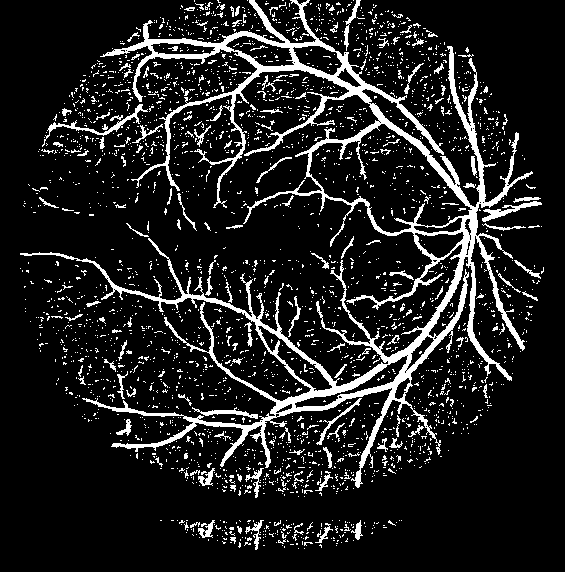

In [22]:
i = np.array(y_pred.reshape(-1, 565)*255, dtype=np.uint8)
IMG.fromarray(i)

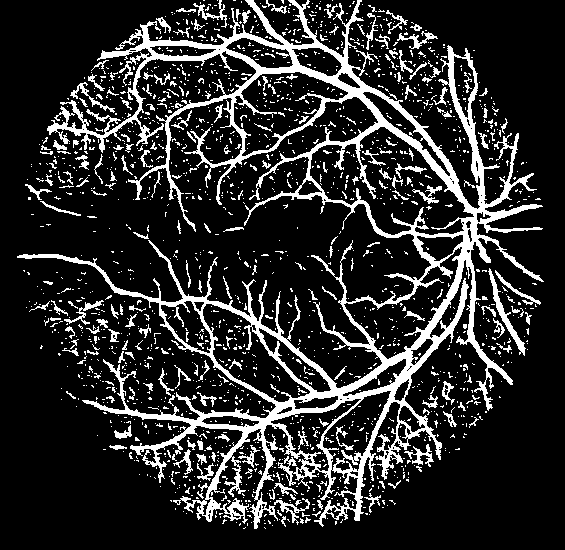

In [39]:
i = np.array(y_pred.reshape(-1, 565)*255, dtype=np.uint8)
IMG.fromarray(i)

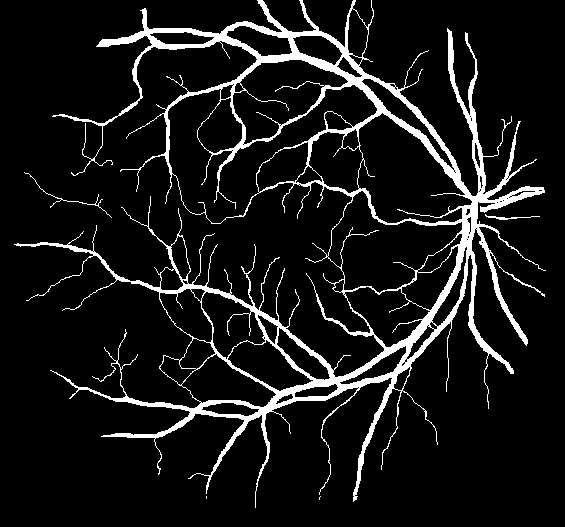

In [22]:
# IMG.fromarray(np.array(y_pred.reshape(584, 54/6)*255, dtype=np.uint8))
i = np.array(y_true.reshape(-1, 565)*255, dtype=np.uint8)
IMG.fromarray(i)

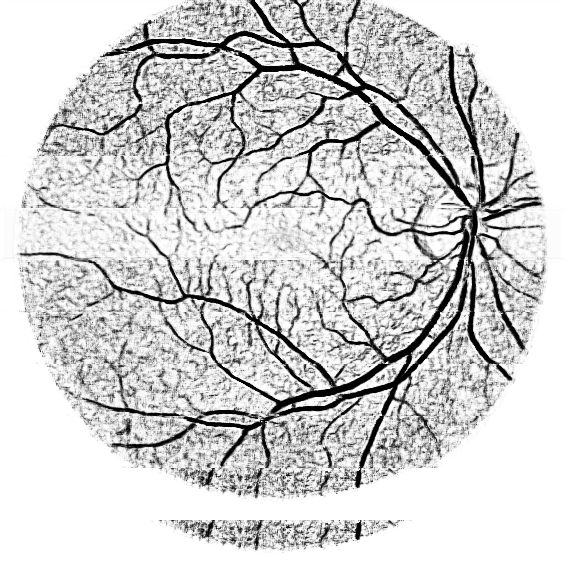

In [23]:
k = scores[:,1,:,:]
i = np.array(np.exp(k).reshape(-1, 565)*255, dtype=np.uint8)
IMG.fromarray(255-i)

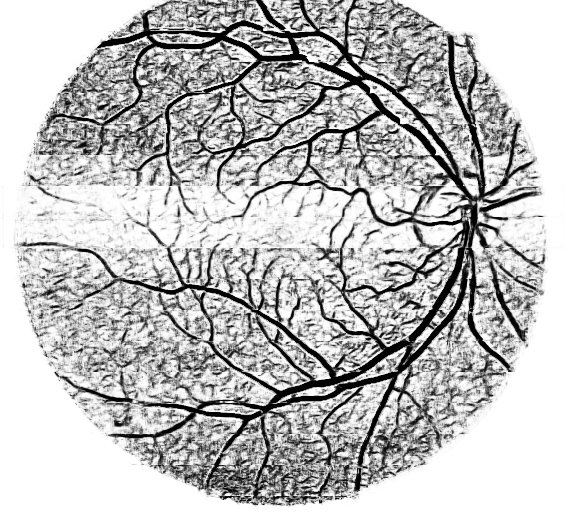

In [17]:
k = scores[:,1,:,:]
i = np.array(np.exp(k).reshape(-1, 565)*255, dtype=np.uint8)
IMG.fromarray(255-i)

In [5]:
# params = {'sk_threshold': 150,
#           'alpha': 7.0,
#           'orig_contrib': 0.3,
#           'seg_threshold': 24}

img_obj = SegmentedImage()

img_obj.load_file(data_dir=Dirs['images'], file_name='b21_training.tif')
img_obj.res['orig'] = img_obj.image_arr[:, :, 1]
img_obj.working_arr = img_obj.image_arr[:, :, 1]

img_obj.load_mask(mask_dir=Dirs['mask'], fget_mask=get_mask_file, erode=True)
img_obj.load_ground_truth(gt_dir=Dirs['truth'], fget_ground_truth=get_ground_truth_file)

# img_obj.generate_skeleton(threshold=params['sk_threshold'])
# img_obj.generate_lattice_graph()

In [7]:
        tot = 0.0
        c = 0
        for x in range(img_obj.working_arr.shape[0]):
            for y in range(img_obj.working_arr.shape[1]):
                if img_obj.mask[x, y] == 255 and img_obj.ground_truth[x, y] == 255:
                    tot += img_obj.working_arr[x, y]
                    c += 1

In [16]:
ig = imgutil.get_image_as_array(Dirs['truth']+sep+'a34_manual1.gif', channels=1)

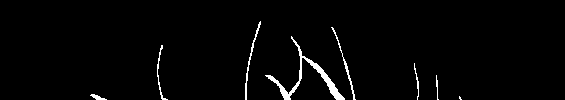

In [22]:
IMG.fromarray(ig[0:100,:])

In [6]:
        c = 0
        for x in range(img_obj.working_arr.shape[0]):
            for y in range(img_obj.working_arr.shape[1]):
                if img_obj.mask[x, y] == 255 and img_obj.ground_truth[x, y] == 255:
                    tot += img_obj.working_arr[x, y]
                    c += 1

NameError: name 'tot' is not defined

In [15]:
IMG.fromarray(img_obj.mask)

NameError: name 'img_obj' is not defined

In [44]:
# tester = AtureTest(out_dir='')
# tester.run(params=params, save_images=False, img_obj=img_obj)
# img_obj.res['scores']

In [58]:
Dirs['truth']

'data/DRIVE/training/1st_manual'

In [65]:
for k in trainset.images:
    print(trainset.images[k].ground_truth.shape)
#     print(trainset.images[k].file_name)

(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)
(584, 565)

In [71]:
str(trainset.train_images).count('reg')


1888

In [13]:
type(trainset.images[0].working_arr)

numpy.ndarray

In [27]:
trainset.images[79].ground_truth.shape

(584, 565, 1)

In [39]:
i = imgutil.get_image_as_array(Dirs['images'] + sep + 'a36_training.tif', channels=3)

In [41]:
i[:,:,1].shape

(584, 565)

In [47]:
a = trainset.images[0]

In [48]:
import copy

In [54]:
b = copy.deepcopy(a)
b.working_arr = b.working_arr * 255

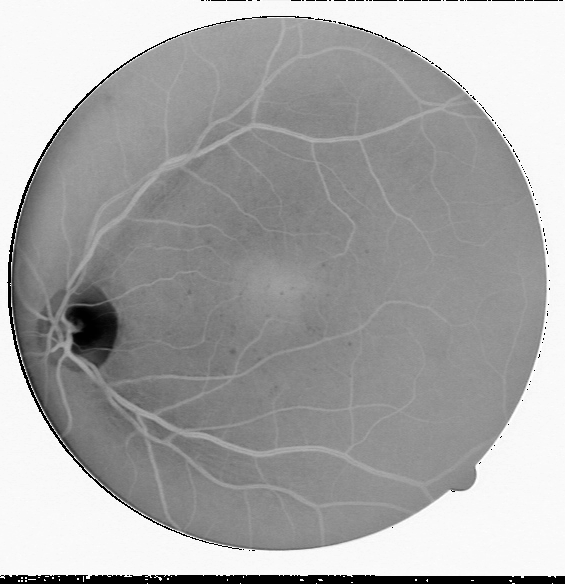

In [56]:
IMG.fromarray(b.working_arr)